# **Analyzing university response to COVID-19**

Over the course of the last few months, COVID-19 has drastically changed and affected lives and businesses all around the world. The following documents does a case study on the impact of COVID-19 on universities across the US.

For our study, we explored [about 1000 universities who have announced their decision](https://www.chronicle.com/article/Here-s-a-List-of-Colleges-/248626). There are 6606 universities in the US. While this data is not truly representative all the universities in the US, it is big enough for us to possible, non-causal trends.


In [0]:
import altair as alt
import pandas as pd
from vega_datasets import data
from datetime import datetime
alt.data_transformers.disable_max_rows()
from altair import datum
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# **The exponential spread of COVID-19 in the US from 01/22/2020 - 06/12/2020**

One sector that is especially facing the repercussions of the virus is the university system in the US. 
Universities started to take measures to combat the implications of the virus in early March. There are many factors that drove the decision making process at each of the colleges.

* Are private colleges more likely to have in-person classes? 
* Has the pandemic disproportionately affected lower ranked colleges? 
* What has been the response of colleges which heavily depend on tuition from out of state and international students?

We’re interested in understanding the motivations and timelines behind how universities in the US have responded to the situation.



In [0]:
counties = alt.topo_feature(data.us_10m.url, 'counties')
states = alt.topo_feature(data.us_10m.url, feature='states')

In [0]:
# Creating US outline by county and state level
state_background = alt.Chart(states).mark_geoshape(
    fill='white',
    stroke='black',
    opacity=0.1
).properties(
    width=700,
    height=500
).project(
    'albersUsa'
)

county_background = alt.Chart(counties).mark_geoshape(
    fill='white',
    stroke='lightgray',opacity=0.1
).encode(
    tooltip="County:N"
).properties(
    width=700,
    height=500
).project(
    'albersUsa'
) 

background = state_background+county_background

In [19]:
##Data from NYT's covid dataset till June 12
covid_counties_NYT = pd.read_csv("https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv")
covid_counties_NYT['date'] =pd.to_datetime(covid_counties_NYT['date'])
covid_counties_NYT["day"] = [int(day.dayofyear) for day in covid_counties_NYT["date"]]
covid_counties_NYT.head()

date     county       state     fips  cases  deaths  day
0 2020-01-21  Snohomish  Washington  53061.0      1       0   21
1 2020-01-22  Snohomish  Washington  53061.0      1       0   22
2 2020-01-23  Snohomish  Washington  53061.0      1       0   23
3 2020-01-24       Cook    Illinois  17031.0      1       0   24
4 2020-01-24  Snohomish  Washington  53061.0      1       0   24

In [18]:
#hacky way to have a list of days (for the text on altair plots)
days =covid_counties_NYT.groupby(["date","day"])[["fips"]].count().reset_index()[['date', 'day']]
days.head()

date  day
0 2020-01-21   21
1 2020-01-22   22
2 2020-01-23   23
3 2020-01-24   24
4 2020-01-25   25

In [17]:
#Cleaning & Pivoting data so that it's in correct form for Altair
covid_counties = (covid_counties_NYT.groupby(["fips","day"]).sum()).reset_index()
covid_counties = covid_counties.pivot("fips",columns="day",values ="cases").fillna(0)
covid_counties = covid_counties.reset_index()
covid_counties=covid_counties[["fips"]+[day for day in range(22,166)]]
covid_counties.columns = ["fips"]+[str(day) for day in range(22,166)]
covid_counties.head()

fips   22   23   24   25   26  ...    160    161    162    163    164    165
0  1001.0  0.0  0.0  0.0  0.0  0.0  ...  273.0  283.0  296.0  316.0  327.0  335.0
1  1003.0  0.0  0.0  0.0  0.0  0.0  ...  335.0  340.0  346.0  358.0  368.0  376.0
2  1005.0  0.0  0.0  0.0  0.0  0.0  ...  198.0  200.0  209.0  215.0  222.0  227.0
3  1007.0  0.0  0.0  0.0  0.0  0.0  ...   82.0   88.0   92.0   96.0  100.0  103.0
4  1009.0  0.0  0.0  0.0  0.0  0.0  ...   75.0   77.0   81.0   89.0   97.0  104.0

[5 rows x 145 columns]

In [0]:
# slider for the graph
slider = alt.binding_range(min=22, max=166, step=7)
selector = alt.selection_single(name="day", fields=['day'],
                                   bind=slider, init={'day': 160})
columns = [str(day) for day in range(22,166)]

In [0]:
# text of the day 
text =alt.Chart(days).mark_text(dy=-200, size=20).encode(
    text='date'
).transform_filter(
    selector
)

In [24]:
# The exponential spread of COVID-19 in the US from 01/22/2020 - 06/12/2020
covid19_spread = background+text+alt.Chart(counties).mark_geoshape(
    stroke='black',
    strokeWidth=0.05
).project(
    type='albersUsa'
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(covid_counties, 'fips', columns)
).transform_fold(
    columns, as_=['week', 'cases']
).transform_calculate(
    day='parseInt(datum.week)'
).encode(
    tooltip = ['cases:Q'],
    color=alt.Color('cases:Q', scale=alt.Scale(
    type='log', base=10, domain=[1, 100000],
    scheme="blues")
  )
).add_selection(
    selector
).transform_filter(
    selector
).properties(
    title={
      "text": ["The exponential spread of COVID-19 in the US from 01/22/2020 - 06/12/2020"], 
      "subtitle": ["\n"],
      "color": "black",
      "font":"24",
      "subtitleColor": "black",
        "fontWeight":"bold"
    }
)
covid19_spread

alt.LayerChart(...)

# **When did U.S. universities start taking action?**


One sector that is especially facing the repercussions of the virus is the University system in the US. 
Colleges started taking action vis-a-vis the virus in early March. We collecyed data of the population densities in each county and plotted the university reponse over time. As you can see in the below graph, some colleges were more proactive than others. 

The population is indicative of the risks of spreading COVID-19. The universities that took earlier actions were in regions along the coast that have high population density.

In [0]:
population = pd.read_csv("https://raw.githubusercontent.com/maruchang/Covid19Hackathon/master/Clean_Datasets/population_counties2019.csv")

In [0]:
population["POP_ESTIMATE_2019"] = [float(i.replace(",","")) for i in population["POP_ESTIMATE_2019"]]

In [0]:
# US map with population estimates in 2019
population_background =background+alt.Chart(counties).mark_geoshape(
).encode(
    tooltip=["Area_Name:N","POP_ESTIMATE_2019:N"],
    color=alt.Color('POP_ESTIMATE_2019:Q', scale=alt.Scale(
      type='log', base=10, domain=[1, 1000000],
      scheme="blues"), legend=alt.Legend(title="2019 Population Est.")
    )
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(population, 'FIPStxt', ['POP_ESTIMATE_2019','FIPStext',"Area_Name"])
).project(
    type='albersUsa'
).properties(
    width=500,
    height=300,
    title=''
)

In [0]:
# Getting the university closure data for spring 2020
closure = pd.read_csv("https://raw.githubusercontent.com/maruchang/Covid19Hackathon/master/Clean_Datasets/closure_spring20.csv",
                      usecols=["Name","Latitude","Longitude","affected_starting"])
closure['affected_starting'] =pd.to_datetime(closure['affected_starting'])
closure=closure.dropna()
closure["day"] = [int(day.dayofyear) for day in closure["affected_starting"]]

In [0]:
# Slider
slider = alt.binding_range(min=67, max=100, step=1, name='day')
selector = alt.selection_single(name="SelectorName", fields=['day'],
                                bind=slider, init={'day': 67})

In [0]:
# Text of the date
text =alt.Chart(days).mark_text(dy=-200, size=20).encode(
    text='date'
).transform_filter(
    selector
)

In [66]:
population_background+text+alt.Chart(closure).mark_circle(filled=True).encode(
    latitude="Latitude",
    longitude="Longitude",
    color=alt.condition(
        'toDate(datum.day) < SelectorName.day[0]',
        alt.value('red'), alt.value('yellow')
    ),
    opacity = alt.condition(selector, alt.value(1.0), alt.value(1.0)),
    tooltip=["Name"]
).add_selection(
    selector
).properties(
    title={
      "text": ["When did U.S. universities start taking action?"], 
      "subtitle": ["The dot representing a college becomes red as they start taking action"],
      "color": "black",
      "font":"20",
      "subtitleColor": "black",
        "fontWeight":"bold"
    }
)

alt.LayerChart(...)

# **Exploring the response of universities**

As the Fall 2020 semester is approaching, universities are in a tough spot to make a decision. The risks and spread of the virus is increasing everyday in many cities. While some universities have announced their decision, others are still waiting to make a decision. The following section discusses different factors that might impact their decision.

## What is the general response?

In general, 66% of the universities are planning to go back to in-person classes. These universities are spread uniformly around the US. The universities that have not yet decided or hybrid model are mostly located around the coast.

In [85]:
df = pd.read_csv("https://raw.githubusercontent.com/maruchang/Covid19Hackathon/master/Clean_Datasets/merged_college_fall2020.csv")
df.rename(columns={'Category':'Response', 'Carnegie Classifation':'Carnegie Classification'}, inplace = True)
df['Carnegie Classification'] = df['Carnegie Classification'].replace('Baccalaureate/Associate\'s Colleges', 'Associate\'s')
df.head()

Unnamed: 0                   Institution  ... foreign Endowment
0           0  Abilene Christian University  ...     2.0   82162.0
1           1            Adelphi University  ...     5.0   20248.0
2           2                Adrian College  ...     NaN   16118.0
3           3           Agnes Scott College  ...    15.0  281391.0
4           4                Albion College  ...     NaN  121935.0

[5 rows x 16 columns]

In [132]:
count_response = df['Response'].value_counts().reset_index()
count_response.columns = ['Response', 'Count']
count_response

Response  Count
0            In-person    398
1  Considering options     61
2            Undecided     46
3         Hybrid model     42
4               Online      4

In [87]:
alt.Chart(count_response).mark_bar().encode(
    x='Count',
    y=alt.Y('Response', sort='-x'),
    color=alt.Color('Response:N', legend=None)
).properties(
    title={
      "text": [""], 
      "subtitle": ["How will universities be operating in Fall 2020?"],
      "color": "black",
      "font":"24"
    }
)

alt.Chart(...)

In [172]:
input_dropdown = alt.binding_select(options=df['Response'].unique())
selection = alt.selection_single(fields=['Response'], bind=input_dropdown, name='Country of')
color = alt.condition(selection,
                    alt.Color('Response:N', legend=alt.Legend(orient='right')),
                    alt.value('transparent'))

points = alt.Chart(df).mark_point(size=30).encode(
    longitude='Longitude',
    latitude='Latitude',
    color=color,
    tooltip=['Institution']
).add_selection(
    selection
)

(background+points)

alt.LayerChart(...)

## How is the Carnegie Classification impacting the response?

In [175]:
carnegie = df.groupby(['Response', 'Carnegie Classification']).size().reset_index(name='Counts')
carnegie.head()

Response Carnegie Classification  Counts
0  Considering options          Baccalaureatte      18
1  Considering options                Master's      22
2  Considering options                Research      21
3         Hybrid model             Associate's       1
4         Hybrid model          Baccalaureatte       5

In [92]:
alt.Chart(carnegie).mark_bar().encode(
    y='Counts',
    x='Response',
    color='Response',
    column= 'Carnegie Classification'
)

alt.Chart(...)

## How are out-of-state and foreign students impacting the response?


In [116]:
travel = df[['Response', 'foreign', 'out-of-state', 'Control']]
travel.columns = ['Response', 'Foreign', 'Out-of-state', 'Control']
travel

Response  Foreign  Out-of-state  Control
0              In-person      2.0          13.0  Private
1           Hybrid model      5.0          10.0  Private
2              In-person      NaN           NaN  Private
3              In-person     15.0          37.0  Private
4              In-person      NaN           NaN  Private
..                   ...      ...           ...      ...
546         Hybrid model      NaN           NaN  Private
547            Undecided     12.0          82.0  Private
548  Considering options      NaN           NaN  Private
549            In-person      1.0          64.0   Public
550            In-person      1.0          13.0   Public

[551 rows x 4 columns]

Text(0.5, 1.0, 'How are colleges that depend on out-of-state \nstudents responding?')

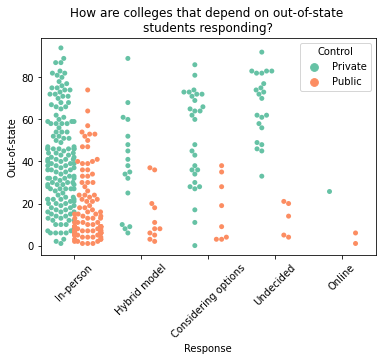

In [117]:
# Out-of-state students
outOfState = travel[travel['Out-of-state'].notna()]
sns.swarmplot(x='Response', y='Out-of-state', hue='Control', dodge='true', data=outOfState, 
               palette='Set2') # Set color palette
plt.xticks(rotation=45)
plt.title("How are colleges that depend on out-of-state \nstudents responding?")

Text(0.5, 1.0, 'How are colleges that depend on foreign \nstudents responding?')

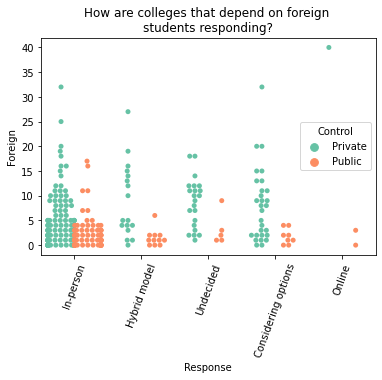

In [118]:
# Foreign students
foreign = travel[travel['Foreign'].notna()]
sns.swarmplot(x='Response', y='Foreign', hue='Control', dodge='true', data=travel, 
               palette='Set2') # Set color palette
plt.xticks(rotation=70)
plt.title("How are colleges that depend on foreign \nstudents responding?")

## Is college endowment impacting the response?

In [109]:
endowment = df[['Response', 'Endowment', "Control"]]
endowment['Endowment'] = np.log10(endowment['Endowment'])
endowment = endowment[endowment['Endowment'].notna()]
endowment

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Response  Endowment  Control
0              In-person   4.914671  Private
1           Hybrid model   4.306382  Private
2              In-person   4.207311  Private
3              In-person   5.449310  Private
4              In-person   5.086128  Private
..                   ...        ...      ...
545            In-person   4.328339  Private
546         Hybrid model   4.663315  Private
547            Undecided   6.184215  Private
548  Considering options   5.255639  Private
549            In-person   4.369272   Public

[406 rows x 3 columns]

Text(0, 0.5, 'Log(Endowment)')

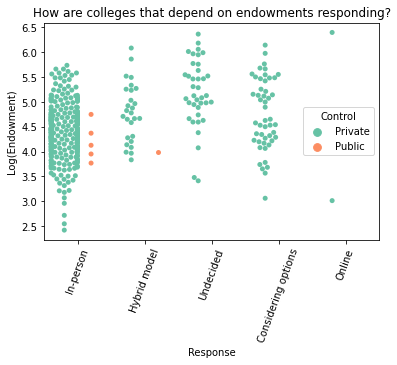

In [174]:
sns.swarmplot(x='Response', y='Endowment', hue='Control', dodge='true', data=endowment, 
               palette='Set2')
plt.xticks(rotation=70)
plt.title("How are colleges that depend on endowments responding?")
plt.ylabel("Log(Endowment)")

## How are the top 150 universities responding?

In [139]:
top150 = pd.read_csv("https://raw.githubusercontent.com/maruchang/Covid19Hackathon/master/Clean_Datasets/merged_top150_fall2020_new.csv")
top150
top150.rename(columns={'Category':'Response'}, inplace = True)
top150 = top150[['Control', 'Response']].reset_index()
top150

index  Control             Response
0        0  Private            Undecided
1        1  Private         Hybrid model
2        2  Private  Considering options
3        3  Private            Undecided
4        4  Private            Undecided
..     ...      ...                  ...
149    149  Private            In-person
150    150   Public            In-person
151    151  Private            In-person
152    152  Private         Hybrid model
153    153   Public            In-person

[154 rows x 3 columns]

In [133]:
response = top150['Response'].value_counts().reset_index()
response.columns = ['Response', 'Count']
response

Response  Count
0            In-person     59
1  Considering options     30
2            Undecided     28
3         Hybrid model     20
4               Online      1

In [146]:
alt.Chart(response).mark_bar().encode(
    x='Count',
    y=alt.Y('Response', sort='-x'),
    color=alt.Color('Response:N', legend=None)
).properties(
    title={
      "text": [""], 
      "subtitle": ["How will the top 150 universities be operating in Fall 2020?"],
      "color": "black",
      "font":"24"
    }
)

alt.Chart(...)

# Conclusion
In conclusion, it was really interesting to see the way the universities in the US responded to COVID-19. There were various factors that affected the reponse such as the geographic location, the population, funding, and the percentage of international and out-of-state students. The behavior of the top 150 universities varied based on this too. Overall, most universities are still planning to have in-person classes this Fall.

Some future work that would be interesting to look at would be to use clustering algorithms to understand what the undecided universities and the universities that are still considering different options are most likely to do and studying how the size of the city or town in which the university is located in impacts its decision.